In [1]:
from datasets import load_dataset
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import io 
import os

In [2]:
cache_directory = "/n/scratch/users/t/thb286/hf_cache"

dataset = load_dataset("tbuckley/synthetic-derm-10k", cache_dir=cache_directory)


shard-00000.tar:   0%|          | 0.00/1.85G [00:00<?, ?B/s]

shard-00001.tar:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
# Example for streaming the dataset:
dataset_iterable = load_dataset("tbuckley/synthetic-derm-10k", streaming=True, cache_dir=cache_directory)
subset = iter(dataset_iterable["train"])
selected_samples = [next(subset) for _ in range(100)]  # Only select the first 100 samples

In [4]:
# Assuming your dataset is already loaded and accessible as dataset["train"]
indices = []
methods = []
submethods = []
labels = []
md5hashes = []

for i, entry in enumerate(dataset["train"]):
    indices.append(i)
    json_data = entry['json']
    methods.append(json_data.get('method', 'Unknown'))
    submethods.append(json_data.get('submethod', 'Unknown'))
    labels.append(json_data.get('label', 'Unknown'))
    md5hashes.append(json_data.get('md5hash', 'Unknown'))

# Create a DataFrame
df = pd.DataFrame({
    'index': indices,
    'method': methods,
    'submethod': submethods,
    'label': labels,
    'md5hash': md5hashes
})


In [7]:
metadata = pd.read_csv("fitz_metadata/fitzpatrick17k.csv")
metadata = metadata.rename(columns={'label': 'label_fitz'})

fitz_merged = df.merge(metadata, on="md5hash")

                           method_submethod  counts
0    finetune_text_to_image / text-to-image    2233
1                finetune_inpaint / inpaint    2231
2       finetune_inpaint / inpaint-outpaint    2140
3  pretrained_text_to_image / text-to-image    1140
4     pretrained_inpaint / inpaint-outpaint    1128
5              pretrained_inpaint / inpaint    1128


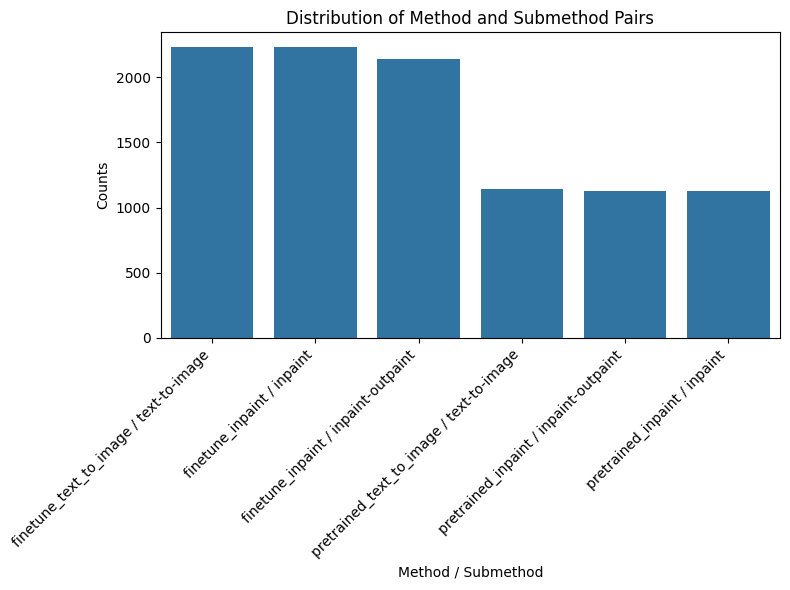

In [8]:
df['method_submethod'] = df['method'] + ' / ' + df['submethod']

method_submethod_counts = df['method_submethod'].value_counts().reset_index()
method_submethod_counts.columns = ['method_submethod', 'counts']

print(method_submethod_counts)

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=method_submethod_counts, x='method_submethod', y='counts')
plt.title('Distribution of Method and Submethod Pairs')
plt.xlabel('Method / Submethod')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

                          label  counts
0                           all    3337
1                     psoriasis    1112
2       squamous-cell-carcinoma     839
3                 lichen-planus     801
4          basal-cell-carcinoma     778
5   allergic-contact-dermatitis     679
6       neutrophilic-dermatoses     541
7           lupus-erythematosus     535
8                   sarcoidosis     518
9               photodermatoses     493
10                 folliculitis     367


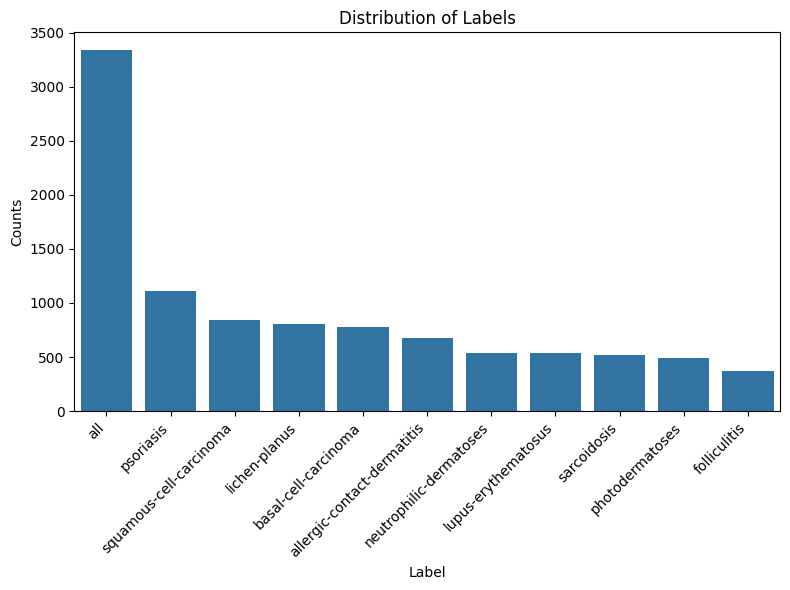

In [9]:
label_counts = fitz_merged['label'].value_counts().reset_index()
label_counts.columns = ['label', 'counts']

print(label_counts)

plt.figure(figsize=(8, 6))
sns.barplot(data=label_counts, x='label', y='counts')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

                         label  counts
0                    psoriasis    1660
1      squamous cell carcinoma    1242
2                lichen planus    1206
3         basal cell carcinoma    1155
4  allergic contact dermatitis    1014
5      neutrophilic dermatoses     839
6          lupus erythematosus     806
7                  sarcoidosis     797
8              photodermatoses     752
9                 folliculitis     529


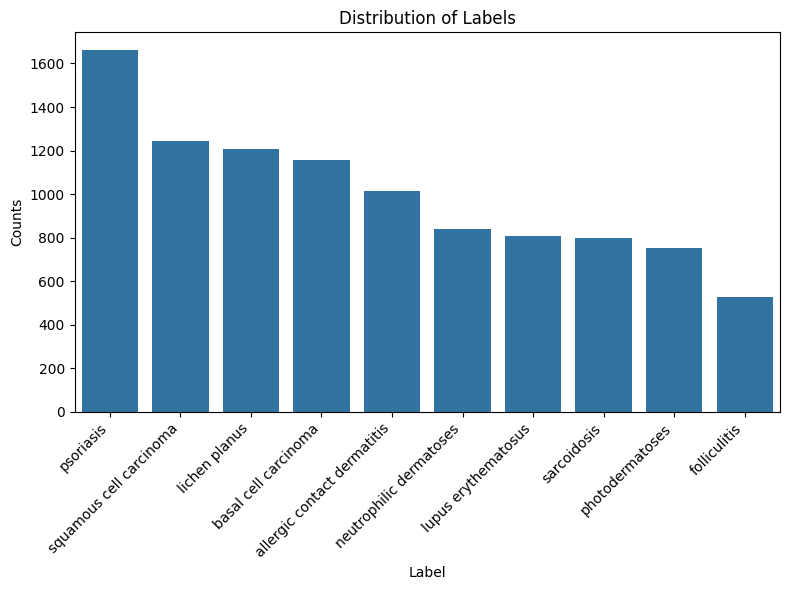

In [10]:
#label_counts = df['label'].value_counts().reset_index()
label_counts = fitz_merged['label_fitz'].value_counts().reset_index()
label_counts.columns = ['label', 'counts']

print(label_counts)

plt.figure(figsize=(8, 6))
sns.barplot(data=label_counts, x='label', y='counts')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
unique_md5hash_count = df['md5hash'].nunique()
print(f'Number of unique md5hash values: {unique_md5hash_count}')

Number of unique md5hash values: 3331


Selected Group:
Method: finetune_inpaint
Submethod: inpaint-outpaint
MD5 Hash: 7d8f14bc6c617b6247380f77be1c8b94


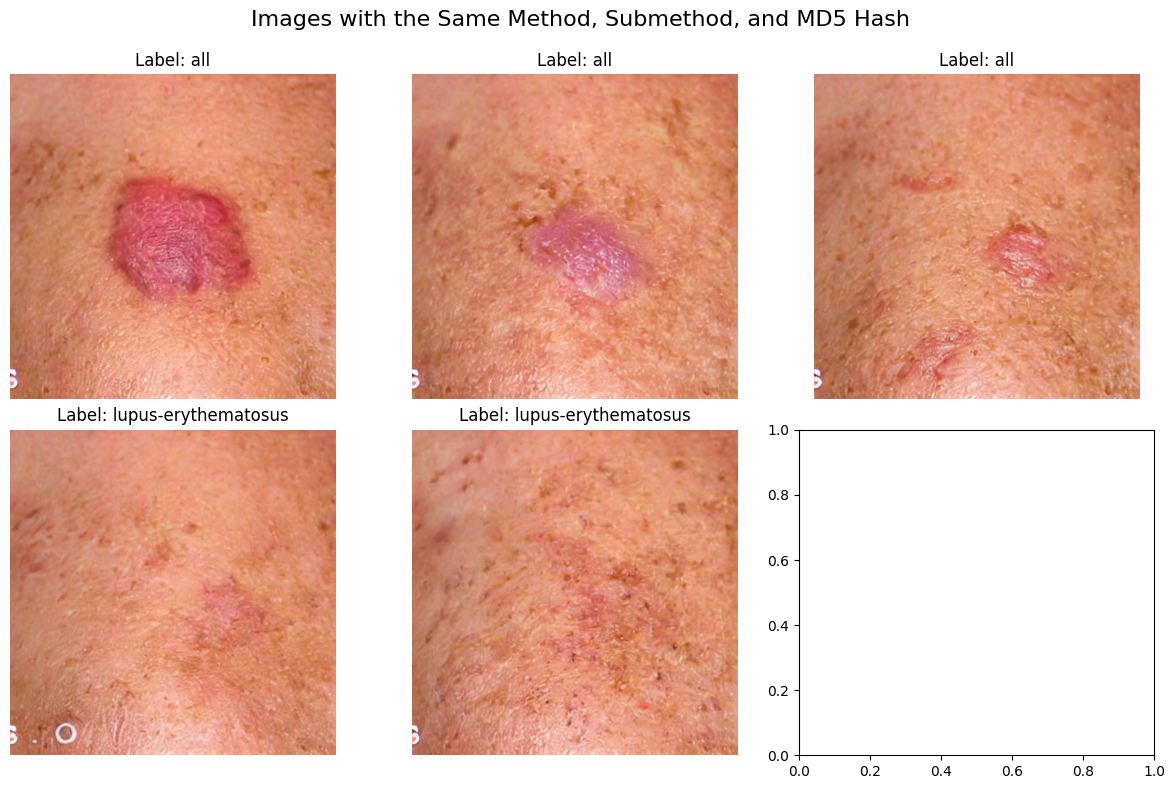

In [13]:
image_index = 2

grouped = df.groupby(['method', 'submethod', 'md5hash']).size().reset_index(name='counts')

groups_with_six_or_more = grouped[grouped['counts'] >= 5]

selected_group = groups_with_six_or_more.iloc[image_index]
selected_method = selected_group['method']
selected_submethod = selected_group['submethod']
selected_md5hash = selected_group['md5hash']

print(f"Selected Group:\nMethod: {selected_method}\nSubmethod: {selected_submethod}\nMD5 Hash: {selected_md5hash}")

matching_entries = df[
    (df['method'] == selected_method) &
    (df['submethod'] == selected_submethod) &
    (df['md5hash'] == selected_md5hash)
]

matching_indices = matching_entries['index'].tolist()[:6]
labels = matching_entries['label'].tolist()[:6]

# Load images one at a time from streamed dataset
images = []
for idx in matching_indices:
    img = next(iter(dataset["train"].skip(idx).take(1)))['png']
    images.append(img)

# Display the images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for img, ax, label in zip(images, axes, labels):
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.suptitle('Images with the Same Method, Submethod, and MD5 Hash', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
